# Training Using Deep Learning

### Import Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import soundfile as sf
from multiprocessing import Pool
import random
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from sklearn.metrics import classification_report
import sklearn

torch.manual_seed(42)

Check if GPU acceleration is available.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Load & Extract Data
This time we will be extracting Mel-Spectrogram.

In [3]:
from mfcc_extraction import make_spectrogram

train_protocol = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
training_file_path = '../data/ASVspoof_Dataset/ASVspoof2019_LA_train/flac/'
training_file_path2 = '../data/The Fake-or-Real (FoR) Dataset (deepfake audio)/training/'
training_data_df = pd.read_csv(train_protocol, delimiter=" ", names=["SPEAKER_ID", "AUDIO_FILE_NAME", "SYSTEM_ID", "-", "KEY"])

# The Fake-or-Real Dataset contains some corrupted files in the training set 
# which have been noted here to avoid
corrupted_files = {"file13424.mp3","file15746.mp3","file16643.mp3","file17407.mp3","file17450.mp3","file19851.mp3","file27206.mp3","file27643.mp3","file27839.mp3","file30959.mp3","file31017.mp3","file32972.mp3","file5323.mp3","file9875.mp3", "file9904.mp3"} 


test_protocol = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'
test_file_path = '../data/ASVspoof_Dataset/ASVspoof2019_LA_eval/flac/'
test_file_path2 = '../data/The Fake-or-Real (FoR) Dataset (deepfake audio)/testing/'
test_data_df = pd.read_csv(test_protocol, delimiter=" ", names=["SPEAKER_ID", "AUDIO_FILE_NAME", "SYSTEM_ID", "-", "KEY"])

batch_size = 32

def multiprocess_spectrograms(paths):
    shape = make_spectrogram(paths[0]).shape
    spectrograms = np.empty((len(paths), shape[0], shape[1]), dtype=np.float32)
    with Pool(os.cpu_count()) as p: 
        for i, spec in enumerate(p.imap(make_spectrogram, paths, chunksize=128)):
            spectrograms[i] = spec
            if i % 1000 == 0:
                print(f'{i}/{len(paths)} spectrograms computed')
        print(f'{len(paths)}/{len(paths)} spectrograms computed') 
    return spectrograms

def file_to_spec_tensor(path):
    return torch.tensor(make_spectrogram(path), dtype=torch.float32).unsqueeze(0)

def check_corrupted(path):
    try:
        sf.read(path, dtype=np.float32)
        return True
    except:
        print("Corrupted:", path)
        return False

def read_FoR_array(path):
    fake_paths_training = []
    real_paths_training = []

    minus_fake = 0
    minus_real = 0

    for file in os.listdir(path + "/fake"):
        curr_path = path + "fake/" + file
        if file not in corrupted_files:
            fake_paths_training.append(curr_path)
        else:
            minus_fake += 1
    for file in os.listdir(path + "/real"):
        curr_path = path + "real/" + file
        real_paths_training.append(curr_path)
    
    paths = np.array(fake_paths_training + real_paths_training)
    labels = np.array([0] * (len(fake_paths_training) - minus_fake) + [1] * (len(fake_paths_training) - minus_real))

    return paths, labels

class log_mel_spect_dataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = torch.tensor(spectrograms, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):

        # feature_tensor = torch.tensor(self.spectrograms[idx], dtype=torch.float32).unsqueeze(0)
        # label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)
        return self.spectrograms[idx], self.labels[idx]


In [10]:
training_paths = training_file_path + training_data_df['AUDIO_FILE_NAME'].to_numpy() + ".flac" 
training_labels = np.array(training_data_df['KEY'].map(lambda x: x == 'bonafide'))
"""
FoR_dataset_training = read_FoR_array(training_file_path2)
training_paths = np.concatenate([training_paths, FoR_dataset_training[0]])
training_labels = np.concatenate([training_labels, FoR_dataset_training[1]])
"""


test_paths = test_file_path + test_data_df['AUDIO_FILE_NAME'].to_numpy() + ".flac" 
test_labels = np.array(test_data_df['KEY'].map(lambda x: x == 'bonafide'))

"""
FoR_Dataset_testing = read_FoR_array(test_file_path2)
test_paths = np.concatenate([test_paths, FoR_Dataset_testing[0]])
test_labels = np.concatenate([test_labels, FoR_Dataset_testing[1]])
"""

print("Computing Training Data:")

training_spectrograms = multiprocess_spectrograms(training_paths)
training_dataset = log_mel_spect_dataset(training_spectrograms, training_labels)
training_loader = DataLoader(training_dataset,
                            batch_size=batch_size,
                            num_workers=0,
                            pin_memory=True,
                            shuffle=True)

print("Computing Test Data:")
test_spectrograms = multiprocess_spectrograms(test_paths)
test_dataset = log_mel_spect_dataset(test_spectrograms, test_labels)
test_loader = DataLoader(test_dataset,
                            batch_size=batch_size,
                            num_workers=0,
                            pin_memory=True)

Computing Training Data:
0/25380 spectrograms computed
1000/25380 spectrograms computed
2000/25380 spectrograms computed
3000/25380 spectrograms computed
4000/25380 spectrograms computed
5000/25380 spectrograms computed
6000/25380 spectrograms computed
7000/25380 spectrograms computed
8000/25380 spectrograms computed
9000/25380 spectrograms computed
10000/25380 spectrograms computed
11000/25380 spectrograms computed
12000/25380 spectrograms computed
13000/25380 spectrograms computed
14000/25380 spectrograms computed
15000/25380 spectrograms computed
16000/25380 spectrograms computed
17000/25380 spectrograms computed
18000/25380 spectrograms computed
19000/25380 spectrograms computed
20000/25380 spectrograms computed
21000/25380 spectrograms computed
22000/25380 spectrograms computed
23000/25380 spectrograms computed
24000/25380 spectrograms computed
25000/25380 spectrograms computed
25380/25380 spectrograms computed
Computing Test Data:
0/71237 spectrograms computed
1000/71237 spectrog

### Build the Model
Convolutional Neural Network

In [5]:
n_epoch = 25

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=43648, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        out = torch.sigmoid(out) #TODO: use logits
        return out

Beginning Training:
Epoch: 1, loss: 181.51175151392817
Epoch: 2, loss: 114.28584747388959
Epoch: 3, loss: 74.05589596834034
Epoch: 4, loss: 48.496906763873994
Epoch: 5, loss: 32.916805524844676
Epoch: 6, loss: 23.675523035926744
Epoch: 7, loss: 18.209614005405456
Epoch: 8, loss: 14.45718649099581
Epoch: 9, loss: 11.690869142883457
Epoch: 10, loss: 9.959507149411365
Epoch: 11, loss: 8.702949521568371
Epoch: 12, loss: 7.397758190134482
Epoch: 13, loss: 6.41631613469508
Epoch: 14, loss: 5.798960205502226
Epoch: 15, loss: 4.801697307950235
Epoch: 16, loss: 4.316260382995779
Epoch: 17, loss: 4.027454898496217
Epoch: 18, loss: 3.6537050743500004
Epoch: 19, loss: 3.294832212268375
Epoch: 20, loss: 2.7655089421605226
Epoch: 21, loss: 2.5872644156070237
Epoch: 22, loss: 2.3446508417146106
Epoch: 23, loss: 2.1783014528746207
Epoch: 24, loss: 1.9696696148803312
Epoch: 25, loss: 1.784604061729624
Finished Training


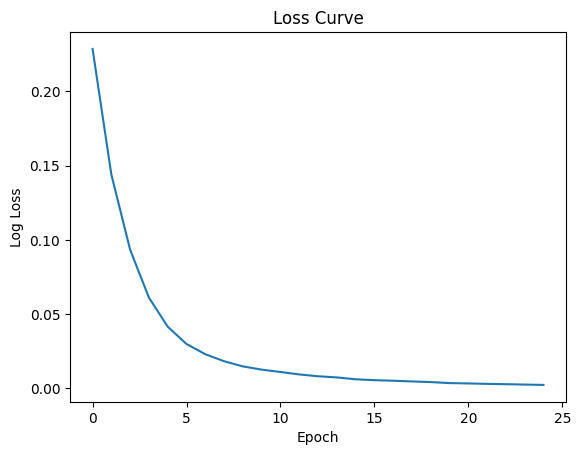

In [ ]:
net = Net()
net.to(device)

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), 
                    lr=0.001,
                    weight_decay=0.0001)

loss_hist = []
def train_model():
    net.train()
    print("Beginning Training:")
    for epoch in range(n_epoch):
        running_loss = 0.0

        for i, data in enumerate(training_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        loss_hist.append(running_loss / len(training_loader))
        print(f'Epoch: {epoch+1}, loss: {running_loss}')
    print('Finished Training')

train_model()

plt.plot(loss_hist)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.show()

### Save the model

In [6]:
PATH = './melspec1_net.pth'

In [10]:
torch.save(net.state_dict(), PATH)

### Evaluating Model Accuracy

In [7]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device)
net.eval()


Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=43648, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=1, bias=True)
)

In [8]:
threshold = 0.5

def predict(path):
    outputs = net(file_to_spec_tensor(path).to(device).unsqueeze(0))
    return (outputs >= threshold).item()

In [ ]:
# You can test certain exaples or files using this function
# print(predict("../data/The Fake-or-Real (FoR) Dataset (deepfake audio)/training/file36.wav"))

In [13]:
correct = 0
total = 0
predictions = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        predicted = (outputs >= threshold)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().detach().numpy())

print(f'Accuracy: {100 * correct // total} %')


Accuracy: 88 %


In [14]:
predictions = np.array(predictions)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       False       0.99      0.87      0.93     63882
        True       0.46      0.94      0.62      7355

    accuracy                           0.88     71237
   macro avg       0.73      0.91      0.77     71237
weighted avg       0.94      0.88      0.90     71237



### Visualize model network

In [23]:
from torchviz import make_dot

data = next(iter(training_loader))
# print(data.shape) # torch.Size([32, 1, 128, 94])


make_dot(net(data[0].to(device)), params=dict(list(net.named_parameters()))).render("rnn_torchviz", format="svg")


'rnn_torchviz.svg'

![Description of the image](../images/rnn_torchviz.svg)


# Generating a Confusion Matrix

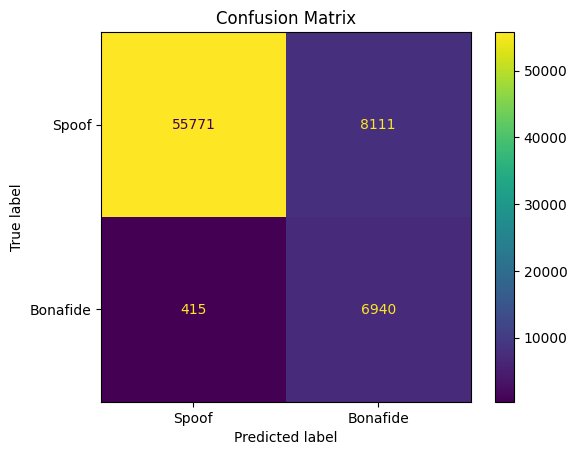

In [19]:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bonafide"])

disp.plot()
plt.title("Confusion Matrix")
plt.show()